
## Notebook illustrating using PYSD and EMA


Exploratory Modeling and Analysis (EMA) is a research methodology that uses computational experiments to analyze complex and uncertain systems [(Bankes, 1993)](http://www.jstor.org/stable/171847?seq=1#page_scan_tab_contents).That is, exploratory modeling aims at offering computational decision support for decision making under deep uncertainty and Robust decision making.

The EMA Workbench is available for download at: https://github.com/quaquel/EMAworkbench

In [12]:
import sys
sys.path
sys.path.append('..your-path../EMAworkbench-master/src')

## Example Simple SIR Model

By combining PySD and EMA we can perform rapidly a large number of experiments and by utilizing Latin Hypercube Sampling we are able to sample over the entire uncertainty space. With the EMA Workbench, we are able to conduct advanced analysis of our simulation results.


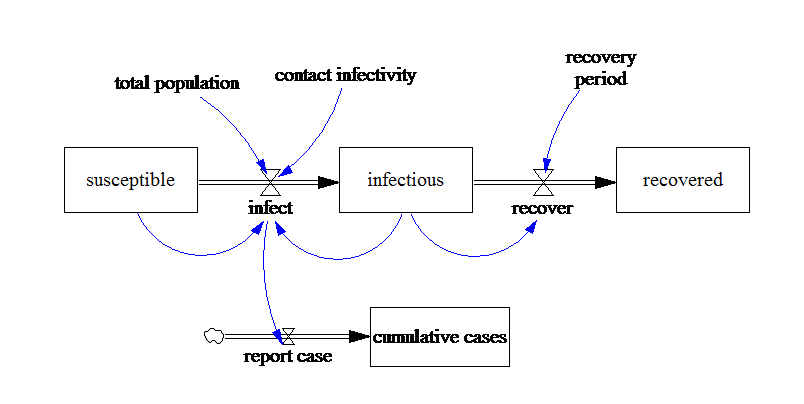

In [6]:
from IPython.display import Image
Image(filename='../../models/SD_Fever/SIR_model.png')

The table below specifies the ranges for the deeply uncertain factor:


| Parameter                      	| Range                               	|
|--------------------------------	|-------------------------------------	|
| contact infectivity	            | 0 - 1                          	    |

In [10]:
%matplotlib inline

In [11]:
from __future__ import (absolute_import, print_function, division,
                        unicode_literals)
from ema_workbench.em_framework import (ModelEnsemble, ModelStructureInterface,
                                        ParameterUncertainty,
                                        CategoricalUncertainty,
                                        Outcome)
from ema_workbench.util import ema_logging, save_results

import numpy as np
import pandas as pd
import pysd

PySD_model = pysd.read_vensim('../../models/SD_Fever/SIR_Simple.mdl')

#============================================================================================
#    Class to specify Uncertainties, Outcomes, Initialize, Run Model and collect outcomes
#============================================================================================
class SimplePythonModel(ModelStructureInterface):
    #specify uncertainties
    uncertainties = [
                     ParameterUncertainty((0, 1), "contact_infectivity")

                    ]
    #specify outcomes 
    outcomes = [Outcome("TIME", time=True),
                Outcome('infectious', time=True),
                Outcome('cumulative_cases', time=True),
                ]
    #Statemenet required syntactically but not used
    def model_init(self, policy, kwargs):
        pass
    #Method to run model
    def run_model(self, kwargs):
        contact_infectivity = kwargs['contact_infectivity']

        results = RunSIRModel(contact_infectivity)
        #Collect outcomes (prepare for saving in tar.gz)
        for i, outcome in enumerate(self.outcomes):
            result = results[i]
            self.output[outcome.name] = np.asarray(result)
#============================================================================================
#    The Model itself
#============================================================================================
def RunSIRModel(contact_infectivity):
   
    SD_result = PySD_model.run(params={
                            'contact_infectivity':contact_infectivity,
                                       })
    
    time = SD_result.index.values

    return (time, SD_result['infectious'], SD_result['cumulative_cases'])

if __name__ == '__main__':
    #np.random.seed(150) #set the seed for replication purposes
    ema_logging.log_to_stderr(ema_logging.INFO)
    model = SimplePythonModel(None, 'simpleModel') #instantiate the model
    ensemble = ModelEnsemble() #instantiate an ensemble
    ensemble.parallel = False #set if parallel computing
    ensemble.model_structure = model #set the model on the ensemble
    nr_experiments = 2000   #Set number of experiments
    results = ensemble.perform_experiments(nr_experiments) #run experiments
    save_results(results, r'../../data/EMA_Results/SIR{}_v1.tar.gz'.format(nr_experiments))

[INFO] 2000 experiment will be executed
[INFO] starting to perform experiments sequentially
[INFO] 100 cases completed
[INFO] 200 cases completed
[INFO] 300 cases completed
[INFO] 400 cases completed
[INFO] 500 cases completed
[INFO] 600 cases completed
[INFO] 700 cases completed
[INFO] 800 cases completed
[INFO] 900 cases completed
[INFO] 1000 cases completed
[INFO] 1100 cases completed
[INFO] 1200 cases completed
[INFO] 1300 cases completed
[INFO] 1400 cases completed
[INFO] 1500 cases completed
[INFO] 1600 cases completed
[INFO] 1700 cases completed
[INFO] 1800 cases completed
[INFO] 1900 cases completed
[INFO] 2000 cases completed
[INFO] experiments finished
[INFO] results saved successfully to ../../data/EMA_Results/SIR2000_v1.tar.gz


#### Make  simple  plots of returned results

[INFO] results loaded succesfully from ../../data/EMA_Results/SIR2000_v1.tar.gz


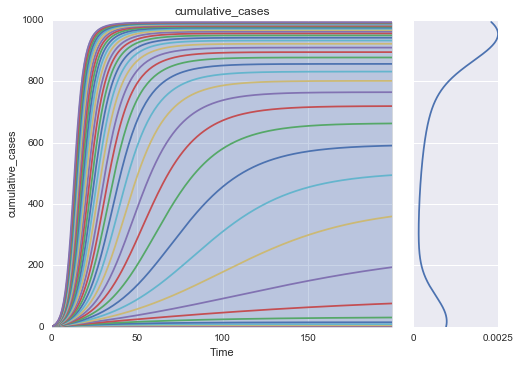

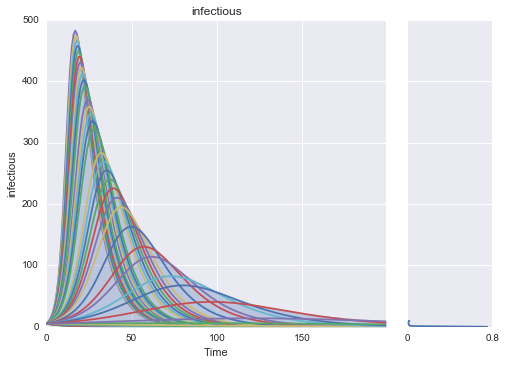

In [5]:
import matplotlib.pyplot as plt

from ema_workbench.analysis.plotting import envelopes, lines, kde_over_time, multiple_densities
from ema_workbench.analysis.plotting_util import KDE, plot_boxplots, LINES, ENV_LIN, BOXPLOT, VIOLIN
from ema_workbench.util import load_results

results = load_results(r'../../data/EMA_Results/SIR2000_v1.tar.gz')
experiments, outcomes = results

oois = outcomes.keys()[:-1]
for ooi in oois:
    data_to_sort_by = outcomes[ooi][:,-1]
    indices = np.argsort(data_to_sort_by)
    indices = indices[1:indices.shape[0]:50]  
    
    lines(results, outcomes_to_show=ooi, density=KDE, show_envelope=True, experiments_to_show=indices)

plt.show()